<a href="https://colab.research.google.com/github/eriosta/neuro/blob/main/Preprocessing_Kirby_2009_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kirby 21 (2009) dataset: https://www.nitrc.org/frs/?group_id=313

Landman BA, Huang AJ, Gifford A, Vikram DS, Lim IA, Farrell JA, Bogovic JA, Hua J, Chen M, Jarso S, Smith SA, Joel S, Mori S, Pekar JJ, Barker PB, Prince JL, van Zijl PC. Multi-parametric neuroimaging reproducibility: a 3-T resource study. Neuroimage. 2011 Feb 14;54(4):2854-66. doi: 10.1016/j.neuroimage.2010.11.047. Epub 2010 Nov 20. PMID: 21094686; PMCID: PMC3020263.

Download and extract .nii files for one subject. The tarball folder has multiple MR sequences, including DTI, T2, fMRI, etc.

In [1]:
! wget --content-disposition https://www.nitrc.org/frs/downloadlink.php/2201

import tarfile

with tarfile.open("KKI2009-01.tar.bz2", "r:bz2") as tar:
    tar.extractall()

--2023-10-12 17:39:27--  https://www.nitrc.org/frs/downloadlink.php/2201
Resolving www.nitrc.org (www.nitrc.org)... 52.3.190.103
Connecting to www.nitrc.org (www.nitrc.org)|52.3.190.103|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://multimodal.projects.nitrc.org/downloads/kki2009/KKI2009-01.tar.bz2 [following]
--2023-10-12 17:39:29--  https://multimodal.projects.nitrc.org/downloads/kki2009/KKI2009-01.tar.bz2
Resolving multimodal.projects.nitrc.org (multimodal.projects.nitrc.org)... 52.3.190.103
Connecting to multimodal.projects.nitrc.org (multimodal.projects.nitrc.org)|52.3.190.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250396987 (239M) [application/x-bzip2]
Saving to: ‘KKI2009-01.tar.bz2’

KKI2009-01.tar.bz2  100%[===================>] 238.80M  18.5MB/s    in 15s     

2023-10-12 17:39:44 (16.4 MB/s) - ‘KKI2009-01.tar.bz2’ saved [250396987/250396987]



In [2]:
! pip install -q nilearn nibabel plotly ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.4 MB/s eta 0:00:00


Visualize one volume for the T2WI sequence

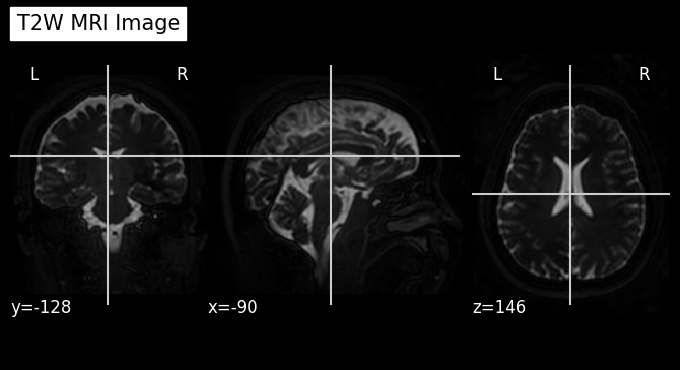

In [3]:
import nibabel as nib
from nilearn import plotting

# Load the .nii file
img = nib.load('/content/KKI2009-01-T2w.nii')

# Since it's a 3D MRI image, directly visualize it
plotting.plot_anat(img, title="T2W MRI Image")
plotting.show()

Visualize all volumes for the T2WI sequence on the sagittal plane

In [4]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# Load the .nii file
img = nib.load('/content/KKI2009-01-T2w.nii')
data = img.get_fdata()

# Number of axial slices
n_slices = data.shape[2]

def plot_slice(slice_idx):
    """
    Visualize a given axial slice using matplotlib.
    """
    plt.figure(figsize=(10, 10))  # Set the figure size
    plt.imshow(np.rot90(data[:, :, slice_idx], -1), cmap='gray', origin='lower')  # Rotate 90 degrees to the right
    plt.title(f"Axial Slice {slice_idx}")
    plt.axis('off')
    plt.show()

# Use ipywidgets to create an interactive slider
interact(plot_slice, slice_idx=IntSlider(min=0, max=n_slices-1, continuous_update=False))


interactive(children=(IntSlider(value=0, continuous_update=False, description='slice_idx', max=255), Output())…

<function __main__.plot_slice(slice_idx)>

Visualize all anatomic volumes for fMRI on all planes. Interestingly, I cannot visualize all brain anatomic. I don't know if this is because of a problem with my visualization approach OR if not all anatomic data is available for the fMRI--since there are other sequences that could be used for anatomy (e.g., T2WI).

In [5]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from ipywidgets import interact, IntSlider

# Load the 4D .nii file
img = nib.load('/content/KKI2009-01-fMRI.nii')

# Get voxel size from the affine transformation
voxel_size = img.header.get_zooms()[:3]

print(f"Voxel size: {voxel_size}")

# Number of volumes
n_volumes = img.shape[-1]

# Function to plot a given volume
def plot_volume(t):
    # Extract the t-th volume
    volume = img.slicer[..., t]

    # Plot in grayscale
    display = plotting.plot_epi(volume, display_mode='ortho', cmap='gray')
    display.title(f"Volume {t}")
    plotting.show()

# Use ipywidgets to create an interactive slider with smoother scrolling experience
interact(plot_volume, t=IntSlider(min=0, max=n_volumes-1, continuous_update=False))


Voxel size: (3.0, 3.0, 3.9729729)


interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=209), Output()), _dom_c…

<function __main__.plot_volume(t)>

### Functional MRI preprocessing:

The `preprocess_data` function uses the `NiftiMasker` class from the `nilearn` library to preprocess functional MRI (fMRI) data. Here's a breakdown of each preprocessing step:

1. **Masking (`mask_img`)**:
    - The data is masked using a specified mask image (`self.mask_img`). This restricts the analysis to a specific region of interest in the brain. Masking helps in reducing the dimensionality of the data by focusing only on the relevant voxels (3D pixels) of the brain. In our implementation, we use `compute_epi_mask` from `nilearn.masking`.

2. **Smoothing (`smoothing_fwhm`)**:
    - Spatial smoothing is applied using a Gaussian kernel. The full width at half maximum (FWHM) of the Gaussian kernel is specified by `self.fwhm`. Smoothing can improve the signal-to-noise ratio and make the data more Gaussian.

3. **Standardization (`standardize`)**:
    - The time series for each voxel is standardized, which means it's transformed to have a mean of 0 and a standard deviation of 1. This can make certain statistical analyses more robust.

4. **Detrending (`detrend`)**:
    - Linear trends within each voxel's time series are removed. This is useful to counteract the effects of scanner drift or other linear artifacts over time.

5. **Temporal Filtering (`t_r`, `high_pass`, `low_pass`)**:
    - The time series data is filtered to remove frequencies outside the specified range.
        - `t_r`: Repetition time (time between scans). This is essential information for the temporal filtering process.
        - `high_pass`: The lower bound of the frequency range to keep in the data.
        - `low_pass`: The upper bound of the frequency range to keep in the data.
    - Filtering helps in removing noise and retaining the frequencies of interest in the fMRI signal.

6. **Memory Level (`memory_level`)**:
    - This indicates the level at which intermediate computations should be cached to save time when re-running the analysis. A level of `1` means that only the most recent operation is cached. Caching can be useful for iterative analyses.

7. **Verbose (`verbose`)**:
    - If set to `1`, the masker will print progress messages, which can be helpful for debugging and understanding the progress of preprocessing.

8. **Confounds (`confounds`)**:
    - The `masker.fit_transform` method can take in `confounds` data. Confounds are variables that represent potential sources of noise or unwanted variability in the fMRI signal. By providing confound regressors, these unwanted effects can be statistically removed from the data during preprocessing.

In summary, this preprocessing pipeline helps in refining the fMRI data by focusing on relevant brain regions, improving the signal quality, removing potential sources of noise or artifacts, and preparing the data for subsequent analyses.

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/content/KKI2009-01-fMRI.nii')
[NiftiMasker.transform_single_imgs] Smoothing images
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


/usr/local/lib/python3.10/dist-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


[MultiNiftiMasker.fit] Loading data from None.
[MultiNiftiMasker.transform] Resampling mask
[DictLearning] Loading data
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/content/KKI2009-01-fMRI.nii')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[DictLearning] Learning initial components
[DictLearning] Computing initial loadings
[DictLearning] Learning dictionary


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:739: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.3. Use 'max_iter' instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
<ipython-input-7-7064ef2249c9>:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


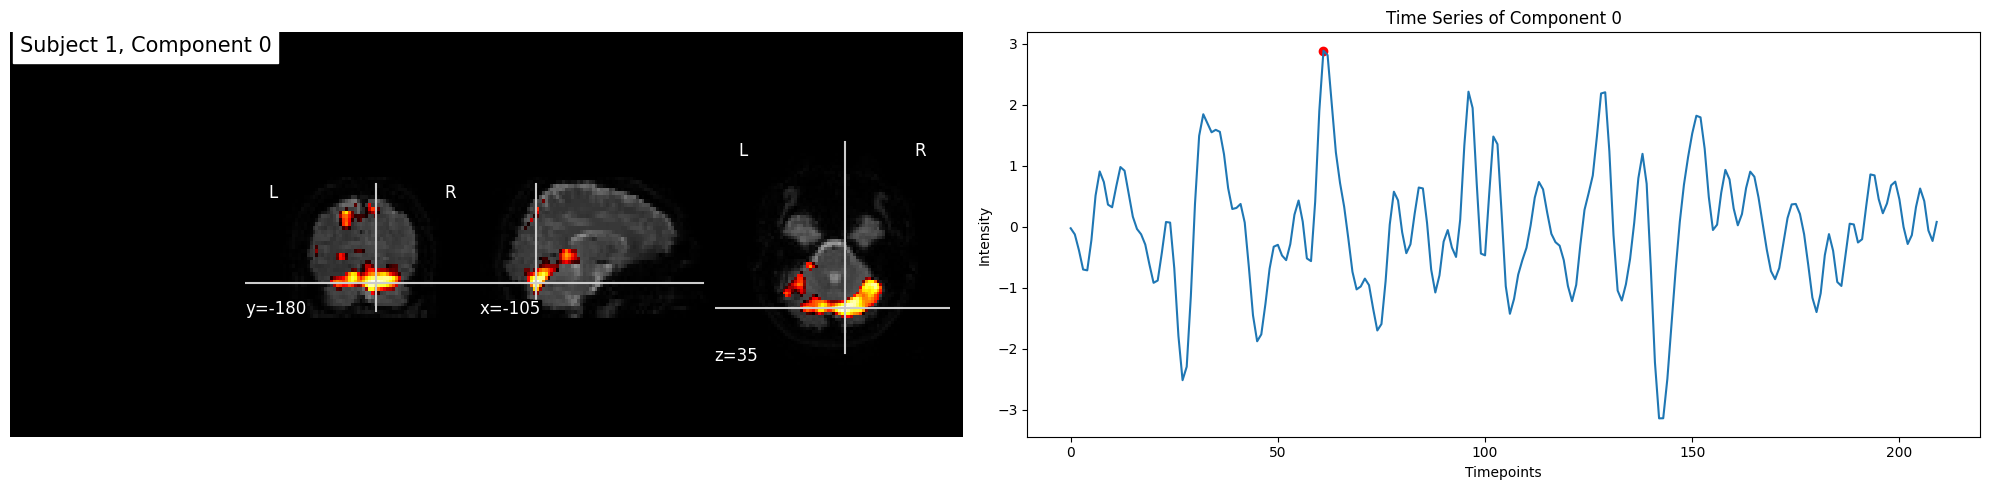

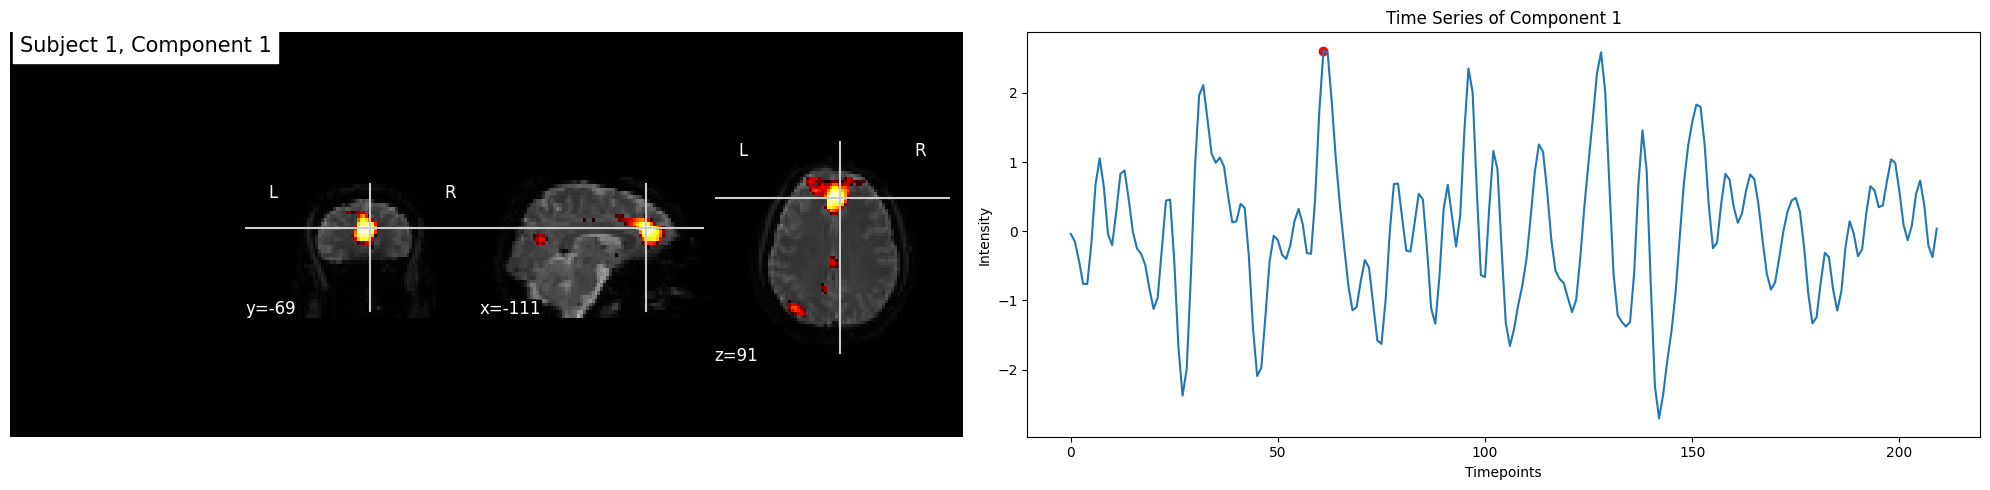

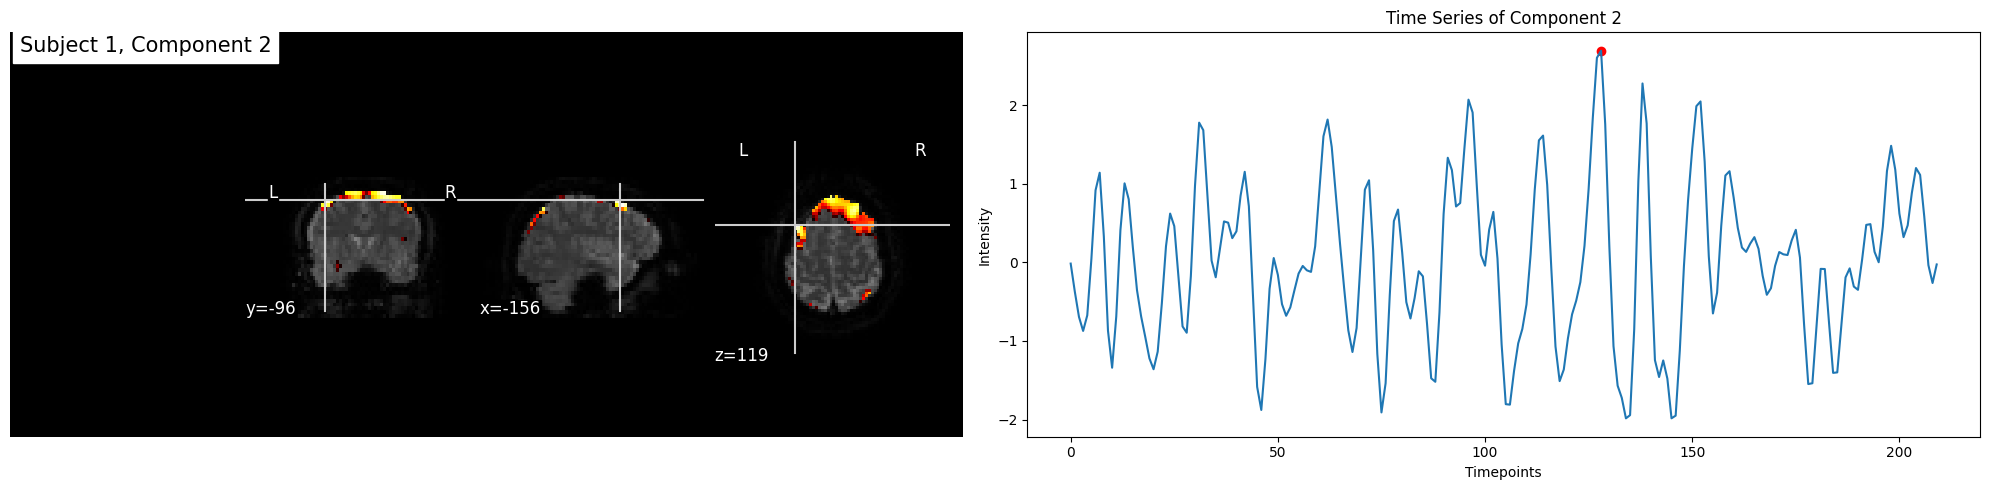

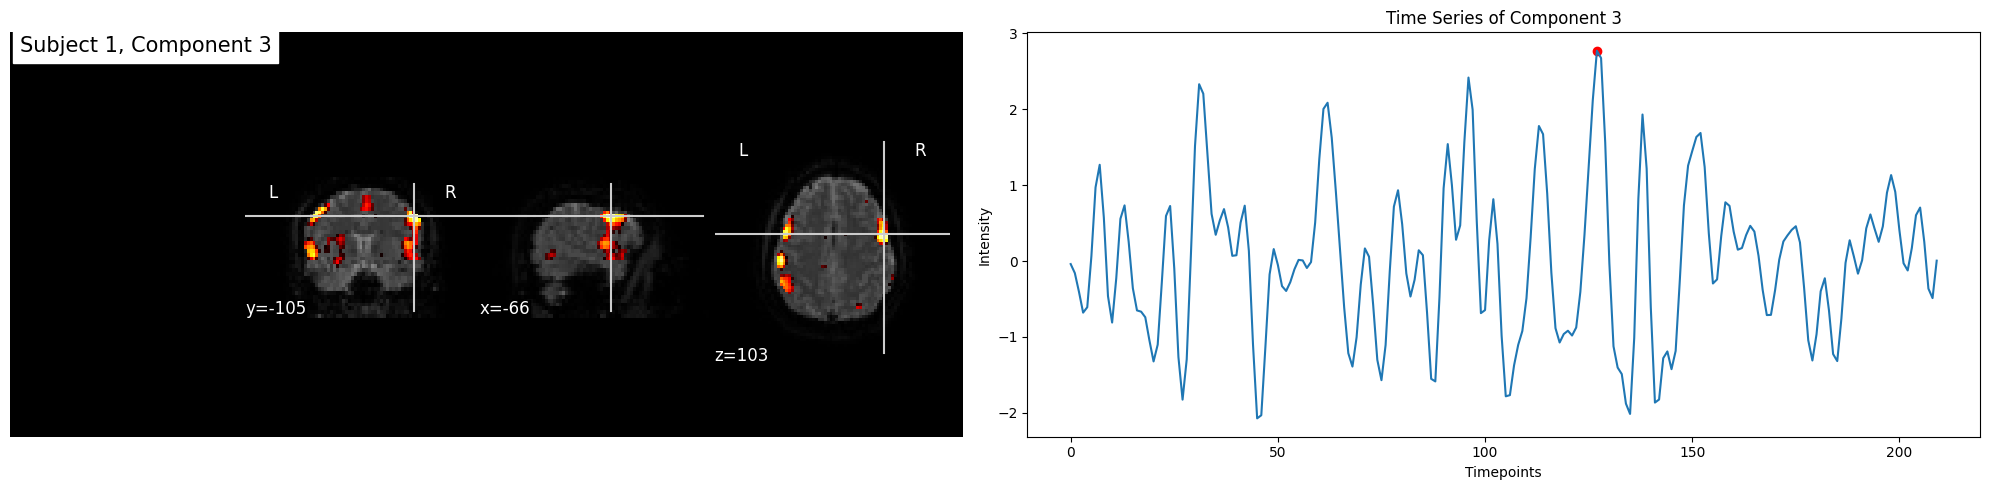

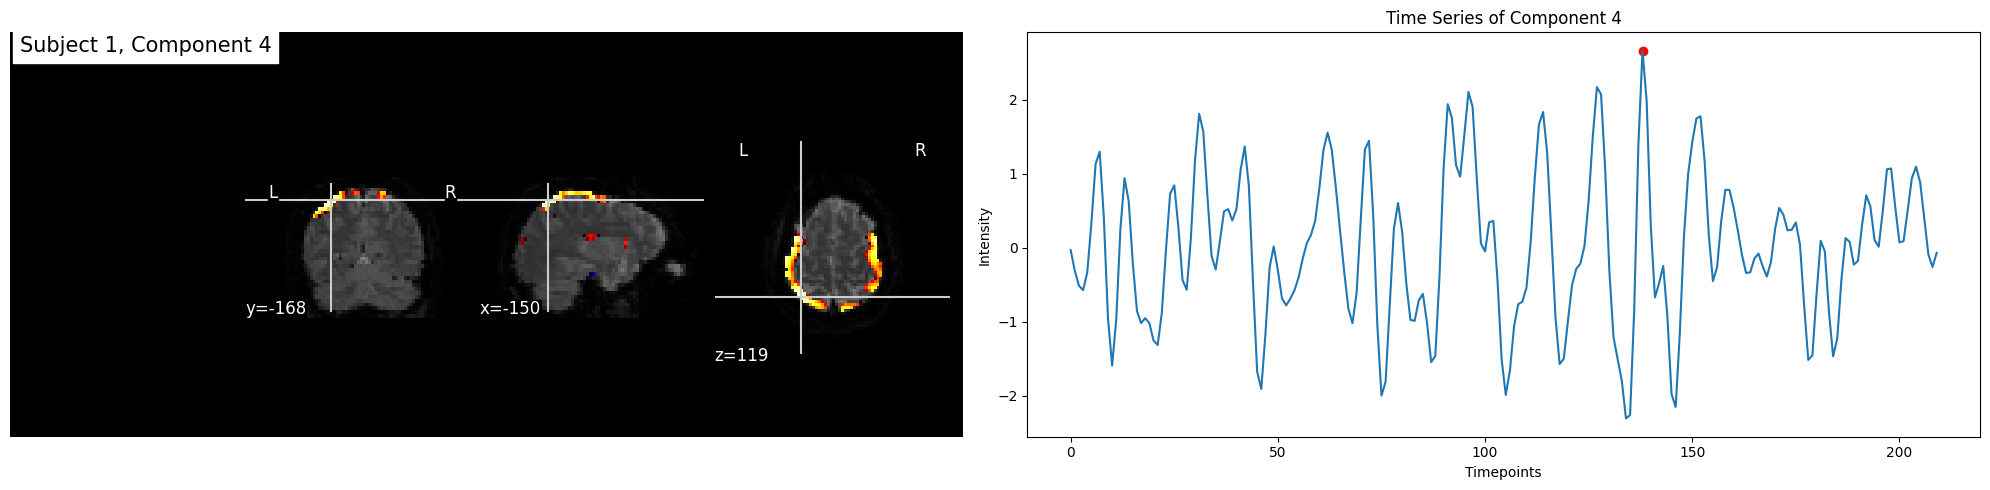

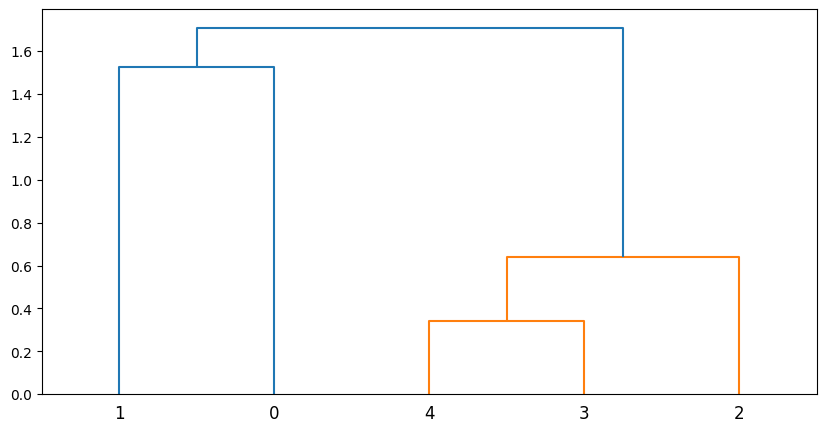

In [7]:
# @title Implementation {display-mode: "form"}

"""
Summary:
========
This code provides functionalities for processing and visualizing functional MRI (fMRI) data.
It loads either a default ADHD dataset or a provided dataset, pre-processes it using a masker,
applies a dictionary learning decomposition method, and then visualizes the resultant components
and their corresponding time series. It also calculates the Pearson correlation between the time
series of different components and plots a dendrogram to showcase the hierarchical clustering of
these components based on their correlation.

Requirements:
- nilearn library for neuroimaging functionalities.
- scipy library for statistical functions and hierarchical clustering.
- plotly and matplotlib libraries for visualization.
- numpy for numerical computations.
- pandas for data handling.
- nibabel library for handling and analyzing NIfTI images.
"""

from nilearn.input_data import NiftiMasker
from nilearn.datasets import fetch_adhd
from nilearn.decomposition import DictLearning
from nilearn.plotting import plot_stat_map, find_xyz_cut_coords
from nilearn.image import index_img
from nilearn.masking import compute_epi_mask, compute_background_mask
import matplotlib.pyplot as plt
import os
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import numpy as np
from scipy.cluster.hierarchy import leaves_list, linkage, fcluster
from scipy.stats import pearsonr
# import streamlit as st
from nilearn import image
import pandas as pd
import plotly.graph_objects as go
from nibabel.affines import apply_affine
from nilearn.input_data import NiftiMasker
from nilearn.image import index_img

class ComponentVisualization:

    def __init__(self, n_subjects=1, n_components=5, fwhm=6, output_dir='component_images', dataset_path=None):
        """Initializes the class with basic configurations and loads the data.

            Parameters:
            -----------
            n_subjects : int
                Number of subjects from the ADHD dataset to load. Default is 1.
            n_components : int
                Number of components for dictionary learning decomposition. Default is 5.
            fwhm : float
                Full width at half maximum for Gaussian smoothing. Default is 10.
            output_dir : str
                Directory to save the component images. Default is 'component_images'.
            dataset_path : str, optional
                Path to a custom dataset. If provided, ADHD dataset won't be loaded. Default is None.

        """

        self.n_subjects = n_subjects
        self.n_components = n_components
        self.fwhm = fwhm
        self.output_dir = output_dir
        self.dataset_path = dataset_path
        self.load_data()
        self.mask_img = compute_epi_mask(self.func_data[0])

    def load_data(self):
        """Loads the dataset (either ADHD or custom) into instance variables."""
        if self.dataset_path:
            self.func_data = [self.dataset_path]
            self.confounds_data = [None]
        else:
            self.adhd_dataset = fetch_adhd(n_subjects=self.n_subjects)
            self.func_data = self.adhd_dataset.func
            self.confounds_data = self.adhd_dataset.confounds

    def preprocess_data(self):
        """Preprocesses the fMRI data using a Nifti masker."""
        masker = NiftiMasker(
            mask_img=self.mask_img,
            smoothing_fwhm=self.fwhm,
            standardize=True,
            detrend=True,          # Remove linear trends
            t_r=2.0,               # Repetition time, adjust if you know the exact value
            high_pass=0.01,       # High pass filter, adjust based on your analysis
            low_pass=0.1,         # Low pass filter, adjust based on your analysis
            memory_level=1,       # Cache intermediate steps
            verbose=1
        )
        self.func_data_cleaned = masker.fit_transform(self.func_data[0], confounds=self.confounds_data[0])

    def apply_decomposition(self):
        """Applies dictionary learning decomposition on the fMRI data."""
        self.dict_learn = DictLearning(
            n_components=self.n_components,
            n_epochs=1,
            alpha=10,
            reduction_ratio='cd',
            random_state=0,
            batch_size=5,
            method='cd',
            mask=self.mask_img,
            smoothing_fwhm=self.fwhm,
            standardize='zscore_sample',
            detrend=True,
            mask_strategy='epi',
            n_jobs=1,
            verbose=1
        )

        # Fit the model to the data
        self.dict_learn.fit(self.func_data[0], confounds=self.confounds_data[0])

        # Transform the data
        self.func_img = [image.concat_imgs(self.func_data)]
        self.func_transformed = self.dict_learn.transform(self.func_img)

        self.components_img = self.dict_learn.components_img_

    def visualize_components(self):
        """Visualizes the components and their time series."""
        os.makedirs(self.output_dir, exist_ok=True)

        # Extract the first volume from the 4D fMRI dataset to use as the anatomical reference
        anat_img = index_img(self.func_data[0], 0)

        for comp in range(self.n_components):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

            # Brain component visualization
            comp_img = index_img(self.components_img, comp)
            title = f'Subject 1, Component {comp}'

            # Determine coordinates of the maximum absolute intensity for better visualization
            abs_max_int_coord = np.unravel_index(np.argmax(np.abs(comp_img.get_fdata())), comp_img.shape)
            cut_coords_abs_max = apply_affine(comp_img.affine, abs_max_int_coord)

            plot_stat_map(comp_img, title=title, display_mode='ortho', colorbar=False,
                          cut_coords=cut_coords_abs_max, axes=ax1, bg_img=anat_img)

            # Time series visualization
            time_series = self.func_data_cleaned[:, comp]
            max_int_timepoint = np.argmax(time_series)
            ax2.plot(time_series)
            ax2.scatter(max_int_timepoint, time_series[max_int_timepoint], color='red')
            ax2.set(title=f'Time Series of Component {comp}', xlabel='Timepoints', ylabel='Intensity')

            plt.tight_layout()
            plt.show()


    def visualize_timeseries_interactive(self):
        """Visualizes the time series of the components in an interactive mode."""
        traces = []

        for comp in range(self.n_components):
            time_series = self.func_data_cleaned[:, comp]
            trace = go.Scatter(
                x=list(range(len(time_series))),
                y=time_series,
                mode='lines',
                name=f'Component {comp}',
                visible=True if comp == 0 else 'legendonly'  # display only the first component by default
            )
            traces.append(trace)

        layout = go.Layout(
            title='Time Series of Components',
            xaxis=dict(title='Timepoints'),
            yaxis=dict(title='Intensity'),
            showlegend=True
        )

        fig = go.Figure(data=traces, layout=layout)
        fig.show()

    def _compute_correlation_matrix(self, p_threshold=0.01, corr_coefficient=0.5):
        """Computes a correlation matrix based on Pearson correlation between components.

        Parameters:
        -----------
        p_threshold : float
            P-value threshold for significance. Default is 0.01.
        corr_coefficient : float
            Correlation coefficient threshold. Default is 0.5.
        """
        self.correlation_matrix = np.zeros((self.n_components, self.n_components))
        self.results = []
        for i in range(self.n_components):
            for j in range(self.n_components):
                data_i = self.func_transformed[0][..., i]
                data_j = self.func_transformed[0][..., j]
                if data_i.size > 1 and data_j.size > 1:
                    correlation, p_value = pearsonr(data_i.ravel(), data_j.ravel())

                    # Check if p-value is significant and correlation is above the threshold
                    if p_value < p_threshold and abs(correlation) > corr_coefficient:
                        self.results.append({
                            'Component_1': i,
                            'Component_2': j,
                            'Pearson_r': correlation,
                            'p_value': p_value
                        })
                        self.correlation_matrix[i, j] = correlation
        self.correlation_matrix = np.nan_to_num(self.correlation_matrix)
        self.correlation_matrix = pd.DataFrame(self.correlation_matrix)

    def _plot_dendrogram(self, streamlit=None):
        """Plots a dendrogram based on the hierarchical clustering of the correlation matrix."""
        linked = linkage(self.correlation_matrix, 'average')
        plt.figure(figsize=(10, 5))
        dendrogram(linked, orientation='top', labels=self.correlation_matrix.columns.tolist(), distance_sort='descending', show_leaf_counts=True)
        plt.show()

        # if streamlit is not None:
        #     st.pyplot()  # Display the dendrogram figure in Streamlit

        # Get the order of the components after hierarchical clustering
        self.ordered_components = leaves_list(linkage(self.correlation_matrix, method='average'))

    def process_and_visualize(self):
        """Complete pipeline to process and visualize the fMRI data."""
        self.preprocess_data()
        self.apply_decomposition()
        # self.visualize_timeseries_interactive()
        self.visualize_components()

        self._compute_correlation_matrix()
        self._plot_dendrogram()

analyzer = ComponentVisualization(n_subjects=1, n_components=5, fwhm=10, dataset_path='/content/KKI2009-01-fMRI.nii')
analyzer.process_and_visualize()